# Introduction

This document concerns how to use the GluonTS implementation of [Level Set Forecaster](https://papers.nips.cc/paper/2021/hash/32b127307a606effdcc8e51f60a45922-Abstract.html). Level Set Forecaster (LSF) is an algorithm for a tabular point prediction algorithm into a probabilistic one.

A tabular point prediction algorithm is an algorithm that takes in tabular data and, at inference, outputs real numbers. Examples include: linear regression, random forests, XGBoost, etc. A tabular probabilistic prediction algorithm is one that at inference outputs an estimate of the conditional distribution.

The high-level description of the LSF algorithm is that it bins the training data in such a manner that the predictions of the feature vectors in each bin are similar. At inference, it then uses the empirical distribution of true values for the bin associated with the new feature vector. We invite those who are interested to read the details and the theoretical guarantees in the [NeurIPS paper](https://papers.nips.cc/paper/2021/hash/32b127307a606effdcc8e51f60a45922-Abstract.html). 

The better your underlying model, the better performing its LSF wrapping will be.

# Retrofitting an Existing Model

Assume that you have trained a tabular point prediction algorithm and named it `underlying_model`. In order to wrap it with LSF, you have to feed into LSF the a dataset from the same distribution that `underlying_model` was trained on:

```
from gluonts.model.rotbaum._model import LSF
model = LSF(model=underlying_model)
model.fit(X_train, y_train, model_is_already_trained=True, min_bin_size=100)
```

It is possible to provide LSF the exact same dataset that `underlying_model` was trained on, but it is not necessary. There is also no assumption that the dataset provided to LSF is the same size as the one provided to `underlying_model`.

The hyperparameter `min_bin_size` is by default `100`. While the NeurIPS paper ensures consistency, under certain conditions, with an increasing `min_bin_size` (of order of magnitude `(ln(n))^2`), in practice we have found that keeping this hyperparameter at `100` works in a surprisingly wide variety of datasets.

Note that some `underlying_model`s assume that `X_train` is a list of lists (or numpy array of numpy arrays), whereas some assume that it is a pandas dataframe. By default LSF works with the former. To apply LSF to the latter, simply set `x_train_is_dataframe=True` in `model.fit`.

Note that while LSF is native to the tabular use case, it is possible to apply it with neural networks as well. To that end, LSF can come in at the embedding level of the architecture. To be a little more explicit, if f1 is the portion of the neural network that embeds the data into a fixed dimensional space, and the remainder of the network is f2, then after training you would cache pairs of embeddings and true target values, and later feed them into LSF together with f2 as the base algorithm. At inference, rather than feeding in the raw data, you would feed the data into f1 to obtain a fixed length feature vector, and only then feed it into the LSF.

# Letting LSF Train the Tabular Model As Well

Letting `model_is_already_trained=False` (as is the default), LSF will train `underlying_model` first and only then wrap it with LSF.

For example:

```
from gluonts.model.rotbaum._model import LSF
from xgboost import XGBModel
underlying_model = XGBModel(
         base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         importance_type='gain', interaction_constraints='',
         learning_rate=0.300000012, max_delta_step=0, max_depth=3,
         min_child_weight=1, monotone_constraints='()',
         n_estimators=50, n_jobs=-1, num_parallel_tree=1,
         objective='reg:squarederror', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
         validate_parameters=1, verbosity=1)
model = LSF(model=underlying_model)
model.fit(X_train, y_train)
```

In case you want LSF to use less data to create the bins than the `underyling_model` uses to train, simply set `max_sample_size`. LSF will then sample `min(max_sample_size, len(X_train)` many data points from the training data without replacement for the purpose of creating the bins.

# LSF Wrapping XGBoost

By default, without specifying an `underlying_model`, LSF will wrap XGBoost with some default parameters:

```
from gluonts.model.rotbaum._model import LSF
model.fit(X_train, y_train)
```

# Inference

If we want to estimate the conditional quantile for a specific quantile (between 0 and 1), simply query it thusly:
```
model.predict(X_test, quantile)
```

One can also retrieve the bin in its entirety, which in turn can be interpreted as an estimated sampling from the conditional distribution. To be precise `model.estimate_dist(X_test)` will output, in pseudocode, `[list of true values whose associated feature vectors are in the same bin as x for x in X_test]`.

One can then plot histograms of the estimated conditional distributions:
```
from matplotlib import pyplot as plt
plt.hist(model.estimate_dist(X_test)[0])
```

# Quick Synthetic Example to Get You Started

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from gluonts.model.rotbaum._model import LSF
import numpy as np

/Users/hashilaf/repos/gluonts-lightgbmfork2/gluon-ts/src/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def weighted_quantile_loss(true, pred, quantile):
    denom = sum(np.abs(true))
    num = sum(
        [
            (1 - quantile) * abs(y_hat - y)
            if y_hat > y
            else quantile * abs(y_hat - y)
            for y_hat, y in zip(pred, true)
        ]
    )
    if denom != 0:
        return 2 * num / denom
    else:
        return None

In [3]:
X_train = [
    [np.random.normal(0, 1), np.random.normal(0, 1)] for i in range(10000)
]
y_train = [i + j + np.random.normal(0, abs(i + j)) for i, j in X_train]
X_test = [
    [np.random.normal(0, 1), np.random.normal(0, 1)] for i in range(10000)
]
y_test = [i + j + np.random.normal(0, abs(i + j)) for i, j in X_test]

In [4]:
underlying_model = LinearRegression()
underlying_model.fit(X_train, y_train)

LinearRegression()

In [5]:
model = LSF(model=underlying_model, min_bin_size=100)
model.fit(X_train, y_train)

In [6]:
P10 = model.predict(X_test, 0.1)
P50 = model.predict(X_test, 0.5)
P90 = model.predict(X_test, 0.9)

0.30368475167009445
0.6872476043155556
0.3032539971588588


(array([ 4.,  4., 14., 19., 28., 14.,  9.,  6.,  1.,  1.]),
 array([-0.99932272, -0.48932945,  0.02066383,  0.53065711,  1.04065038,
         1.55064366,  2.06063693,  2.57063021,  3.08062348,  3.59061676,
         4.10061004]),
 <BarContainer object of 10 artists>)

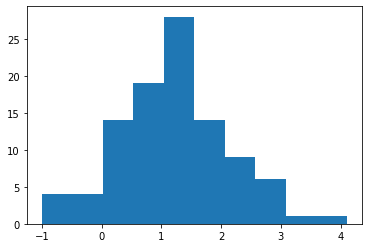

In [7]:
print(weighted_quantile_loss(y_test, P10, 0.1))
print(weighted_quantile_loss(y_test, P50, 0.5))
print(weighted_quantile_loss(y_test, P90, 0.9))
plt.hist(model.estimate_dist([[0.5, 0.5]])[0])

In [8]:
model.estimate_dist([[0.5, 0.5]])[0]

[2.288148404849137,
 1.574696116254158,
 0.6568102103240447,
 2.2993520742685227,
 0.39109241176636667,
 1.7025821798202085,
 0.6855239431277019,
 1.0452498711450835,
 1.512439052988055,
 0.8593260692605851,
 -0.6962483603681517,
 0.139817808528079,
 1.64273291259174,
 1.1756085357251278,
 1.2286820644502852,
 2.327047163989284,
 0.44771284640985787,
 1.467409266835301,
 0.9302439674991858,
 1.03700532459507,
 0.008129538932130087,
 1.1368726098692654,
 1.6079078731856582,
 -0.2317150940367927,
 0.675471791654082,
 2.0313939483686605,
 0.8312038376464166,
 1.645705787029204,
 0.48299689048994443,
 1.579827037650825,
 1.165238373622516,
 1.190270554221262,
 1.4542366173260606,
 1.2644800116574475,
 1.4307864289204961,
 0.7068177077124251,
 0.13010745707289473,
 1.2251120802386763,
 0.3693318284416732,
 1.1352689844230193,
 1.9552669587197022,
 2.4357911384654534,
 -0.0026836468661575186,
 1.2065815093215613,
 2.0651693948249856,
 0.6721360437208823,
 1.0491761310070071,
 3.2172861439696

The bins in their entirety are stored in `model.id_to_bins`:

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <BarContainer object of 10 artists>)

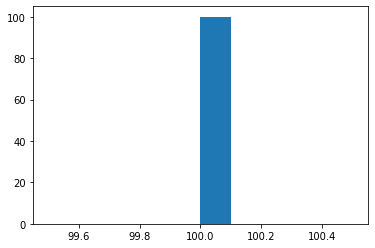

In [9]:
plt.hist([len(model.id_to_bins[id]) for id in model.id_to_bins])